# Test online learning in DeepNets



In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger
from time import time


from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

Using Theano backend.
/Users/admin/.virtualenvs/keras_0_3_2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [3]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train_org, y_train_org), (X_test_org, y_test_org) = mnist.load_data()
print("X_train original shape", X_train_org.shape)
print("y_train original shape", y_train_org.shape)
print("X_test original shape", X_test_org.shape)
print("y_test original shape", y_test_org.shape)

('X_train original shape', (60000, 28, 28))
('y_train original shape', (60000,))
('X_test original shape', (10000, 28, 28))
('y_test original shape', (10000,))


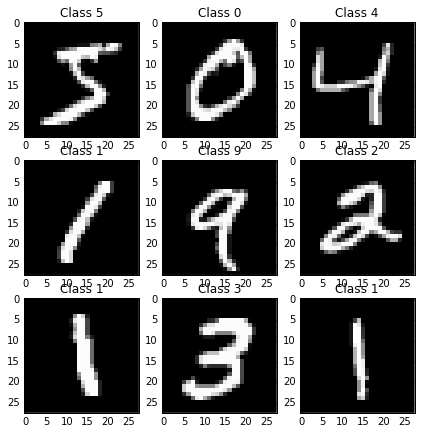

In [5]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train_org[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train_org[i]))

In [6]:
X_train = X_train_org
y_train = y_train_org
X_test = X_test_org
y_test = y_test_org

In [7]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

('Training matrix shape', (60000, 784))
('Testing matrix shape', (10000, 784))


In [8]:
# get 1-hot representation for the 10 classes
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [9]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.
                           
model.add(Dropout(0.4))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [11]:
offline_history = model.fit(X_train, Y_train,
          batch_size=128, nb_epoch=4,
          show_accuracy=True, verbose=1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 6s - loss: 0.3224 - acc: 0.9018 - val_loss: 0.1176 - val_acc: 0.9653
Epoch 2/4
60000/60000 [==============================] - 7s - loss: 0.1409 - acc: 0.9573 - val_loss: 0.0900 - val_acc: 0.9712
Epoch 3/4
60000/60000 [==============================] - 7s - loss: 0.1099 - acc: 0.9657 - val_loss: 0.0765 - val_acc: 0.9762
Epoch 4/4
60000/60000 [==============================] - 8s - loss: 0.0922 - acc: 0.9715 - val_loss: 0.0716 - val_acc: 0.9786


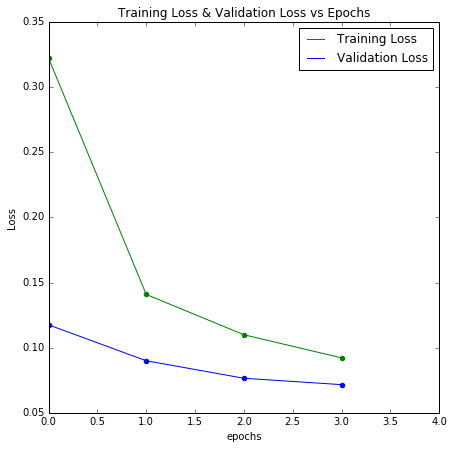

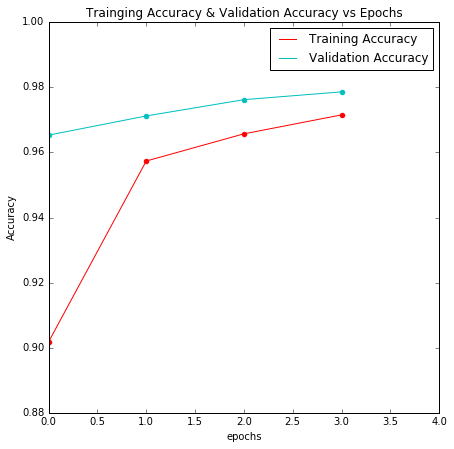

In [12]:
hist = offline_history

plt.figure(1)

axes = plt.gca()
x_min = hist.epoch[0]
x_max = hist.epoch[-1]+1
axes.set_xlim([x_min,x_max])

plt.scatter(hist.epoch, hist.history['loss'], color='g')
plt.plot(hist.history['loss'], color='g', label='Training Loss')
plt.scatter(hist.epoch, hist.history['val_loss'], color='b')
plt.plot(hist.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss & Validation Loss vs Epochs')
plt.legend()

plt.figure(2)

axes = plt.gca()
x_min = hist.epoch[0]
x_max = hist.epoch[-1]+1
axes.set_xlim([x_min,x_max])

plt.scatter(hist.epoch, hist.history['acc'], color='r')
plt.plot(hist.history['acc'], color='r', label='Training Accuracy')
plt.scatter(hist.epoch, hist.history['val_acc'], color='c')
plt.plot(hist.history['val_acc'], color='c', label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Trainging Accuracy & Validation Accuracy vs Epochs')
plt.legend()

plt.show()

In [13]:
loss, acc = model.evaluate(X_test, Y_test,
                       show_accuracy=True, verbose=0)
print('Test score:', loss)
print('Test accuracy:', acc)

('Test score:', 0.071622414178214966)
('Test accuracy:', 0.97860000000000003)


In [14]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

10000/10000 [==============================] - 0s     


In [15]:
print len(correct_indices)

9786


In [16]:
print len(incorrect_indices)

214


## Lets go the online way !

In [17]:
model_online = Sequential()
model_online.add(Dense(512, input_shape=(784,)))
model_online.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.
                           
model_online.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model_online.add(Dense(512))
model_online.add(Activation('relu'))
model_online.add(Dropout(0.2))
model_online.add(Dense(10))
model_online.add(Activation('softmax'))

In [18]:
model_online.compile(loss='categorical_crossentropy', optimizer='adam')

In [19]:
no_of_samples = len(X_train)

batch_size = 1
nb_classes = 10
nb_epoch = 1
start_time = 0
end_time = 0

In [20]:
from keras.callbacks import Callback

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [28]:
online_history = LossHistory()

In [34]:
def compute_regret(model,X,Y):
    
    predicted_classes = model.predict_classes(X)
    
    correct_indices = np.nonzero(predicted_classes == Y)[0]
    incorrect_indices = np.nonzero(predicted_classes != Y)[0]
    
    return (correct_indices, incorrect_indices)

In [29]:
no_of_samples = 5000

train_score_list = []
test_score_list = []

for i in range(no_of_samples):
    
    # print info after consuming 1000 data points
    if ((i+1)%1000 == 0):
        print("Example : %d", i)
        end_time = time()
        time_lapse = end_time - start_time
        print("Training on 1000 point took %.2f secs" %(end_time - start_time))
        start_time = time()
        #start_time = time()

    # train on ith data point
    model_online.fit(X_train[i:i+1,:], Y_train[i:i+1],
          batch_size, nb_epoch,
          show_accuracy=True, verbose=0)
    
    #calculate regret on train and test
    

('Example : %d', 1000)
Training on 1000 point took 804.04 secs
('Example : %d', 2000)
Training on 1000 point took 19.77 secs
('Example : %d', 3000)
Training on 1000 point took 20.89 secs
('Example : %d', 4000)
Training on 1000 point took 21.22 secs


In [31]:
test_score = model_online.evaluate(X_test, Y_test, show_accuracy=True, verbose=0)
test_score_list.append(test_score)
    
train_score = model_online.evaluate(X_train, Y_train,
                           show_accuracy=True, verbose=0)
    
train_score_list.append(train_score)

In [32]:
test_score

[0.49876660203933715, 0.88780000000000003]

In [33]:
train_score

[0.49518192291259766, 0.88856666666666662]

In [50]:
(correct, incorrect) = compute_regret(model_online, X_train, y_train_org)

60000/60000 [==============================] - 1s     


In [51]:
correct

array([    0,     1,     2, ..., 59997, 59998, 59999])

In [52]:
incorrect

array([   24,    28,    33, ..., 59957, 59973, 59980])

In [53]:
len(correct_indices)

59292

In [54]:
len(incorrect_indices)

708

In [18]:
score = model_online.evaluate(X_test, Y_test,
                       show_accuracy=True, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

('Test score:', 0.29842942390441896)
('Test accuracy:', 0.93969999999999998)


In [19]:
predicted_classes = model_online.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

10000/10000 [==============================] - 0s     


In [20]:
print len(correct_indices)

9397


In [21]:
print len(incorrect_indices)

603
